In [1]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from futils import loaders
import pandas as pd
from futils.comparison_util import Linreg

%matplotlib widget
def widgeter(protpath, ligpath, cnndatapath, title, key = None):
    cnndata = loaders.load_bulk2(cnndatapath)
    with open(protpath) as file:
        protstring = file.read()
    ligs = [lig for lig in Chem.SDMolSupplier(ligpath)]

    if key is None:
        key = cnndata["CNNscore"].sort_values().index[::-1]
    elif key == "ascending":
        key = cnndata["CNNscore"].sort_values().index
    elif key == "affinity":
        key = cnndata["CNNaffinity"].sort_values().index[::-1]
    elif key == "affinity_ascending":
        key = cnndata["CNNaffinity"].sort_values().index
    
    p = py3Dmol.view(width=800,height=400)
    lig = Chem.SDMolSupplier(ligpath)[0]
    p.addModel(protstring)
    # p.setStyle({"model": -1}, {"cartoon": {"color": "spectrum"}})
    p.setStyle({"model": -1}, {"cartoon": {}})
    p.addModel(Chem.MolToMolBlock(lig), "sdf")
    p.setStyle({"model": -1}, {"stick": {}})
    p.zoomTo()
    def setframe(p, i, ligs, key = list(range(len(ligs)))):
        idx = key[i]
        p.removeModel()
        p.addModel(Chem.MolToMolBlock(ligs[idx]), "sdf")
        p.setStyle({"model": -1}, {"stick": {}})
        # p.setStyle({"model": -1}, {"stick": {"color": "red"}})
        return p.show()

    i = widgets.BoundedIntText(
        value=1,
        min=0,
        max=len(ligs),
        step=1,
        description='Index:',
    )
    
    def printer(i, key = list(range(len(ligs)))):
        idx = key[i]
        print(f"Drug: {ligs[idx].GetProp('_Name')}")


    out1 = widgets.interactive_output(setframe, {"p": fixed(p), "i": i, "ligs": fixed(ligs), "key": fixed(key)})
    out2 = widgets.Output()
    out3 = widgets.interactive_output(printer, {"i": i, "key": fixed(key)})
    with out2:
        fig, axes = plt.subplots(1, 2, figsize = (4,3))
    fig.suptitle(title)
    scorebar = axes[0].bar([0], [1])[0]
    affinitybar = axes[1].bar([0], [cnndata["CNNaffinity"].max() * 1.1])[0]

    def updatebar(change):
        idx = key[change.new]
        scorebar.set_height(cnndata.loc[idx, "CNNscore"])
        affinitybar.set_height(cnndata.loc[idx, "CNNaffinity"])
        fig.canvas.draw()

    axes[0].xaxis.set_ticklabels([])
    axes[0].tick_params(bottom = False)
    axes[0].set_xlabel("CNNscore", fontsize = 12)
    axes[0].set_xlim((-1, 1))

    axes[1].xaxis.set_ticklabels([])
    axes[1].tick_params(bottom = False)
    axes[1].set_xlabel("CNNaffinity", fontsize = 12)
    axes[1].set_xlim((-1, 1))

    i.observe(updatebar, "value")
    i.value = 0
    sideview = widgets.HBox([out1, out2])
    display(sideview)
    display(widgets.HBox([i, out3]))

def plothists(cnndata, title):
    fig, axes = plt.subplots(1, 2, figsize = (10, 4))
    fig.suptitle(title)
    axes[0].hist(cnndata["CNNscore"])
    axes[0].set_xlabel("CNNscore", fontsize = 20)
    axes[1].hist(cnndata["CNNaffinity"])
    axes[1].set_xlabel("CNNaffinity", fontsize = 20)

glide = pd.read_csv("/home/qzj517/POR-DD/data/raw_data/cyp_screen/docking_results.csv")
glide = glide.drop(columns = glide.columns[0])
glide = glide.rename(columns = {"Drug": "name"})
glide["name"] = glide["name"].str.replace(" ", "_")
glide["glidebest"] = -glide.loc[:, "score_1":].T.min()

# random RDkit -> EquiBind -> gnina minimize

Drug: Pyridoxal Phosphate


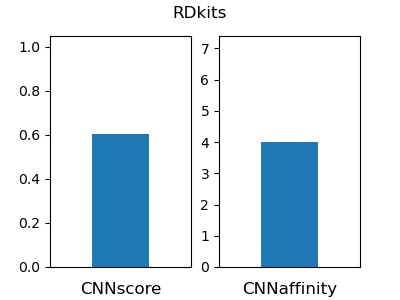

In [3]:
protpath = "/home/qzj517/POR-DD/data/raw_data/cyp_screen/protein.pdb"
ligpath = "/home/qzj517/POR-DD/data/gnina_processed/cyp_screen_differences/cyp_screen_rdkit.sdf"
cnndatapath = "/home/qzj517/POR-DD/data/gnina_processed/cyp_screen_differences/cyp_screen_rdkit.txt"
title = "RDkits"
cnndata = loaders.load_bulk2(cnndatapath)
%matplotlib widget
widgeter(protpath, ligpath, cnndatapath, title, key = list(range(len(cnndata))))

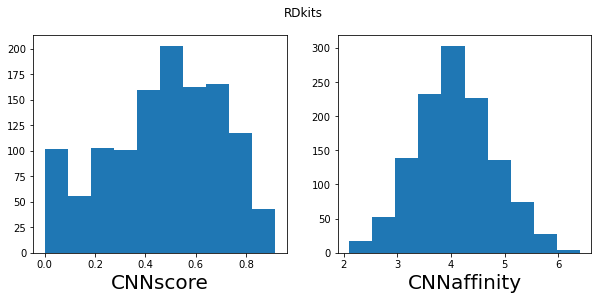

In [4]:
%matplotlib inline
plothists(cnndata, title)

Text(0, 0.5, 'Best binding glide')

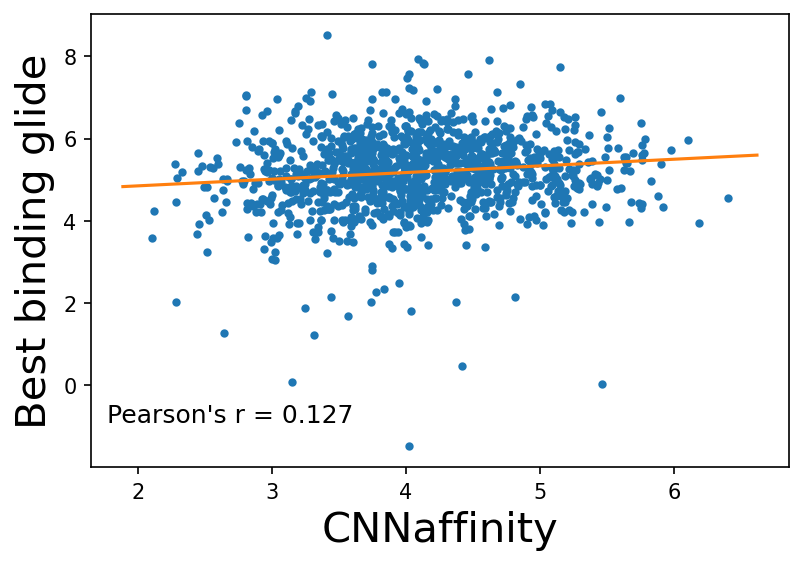

In [12]:
merge = cnndata.merge(glide[["name", "glidebest"]], on="name")
fig, ax = plt.subplots(dpi = 150)
mask = pd.Series([True]*len(merge))
# mask = merge["CNNscore"] > 0.8
x = list(merge["CNNaffinity"][mask])
y = list(merge["glidebest"][mask])
Linreg(x, y, ax = ax, fontsize = 12)
plt.gca().set_xlabel("CNNaffinity", fontsize = 20)
plt.gca().set_ylabel("Best binding glide", fontsize = 20)

# unproccessed structures -> gnina minimize with autobox ligand

Drug: Norflurane


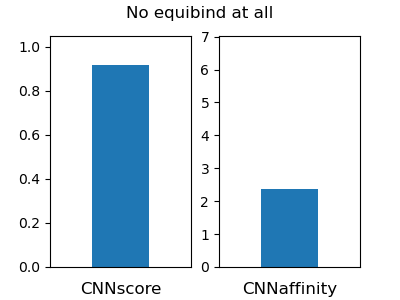

In [13]:
protpath = "/home/qzj517/POR-DD/data/raw_data/cyp_screen/protein.pdb"
ligpath = "/home/qzj517/POR-DD/data/gnina_processed/cyp_screen_differences/cyp_screen_dumb.sdf"
cnndatapath = "/home/qzj517/POR-DD/data/gnina_processed/cyp_screen_differences/cyp_screen_dumb.txt"
title = "No equibind at all"
cnndata = loaders.load_bulk2(cnndatapath)
%matplotlib widget
widgeter(protpath, ligpath, cnndatapath, title)

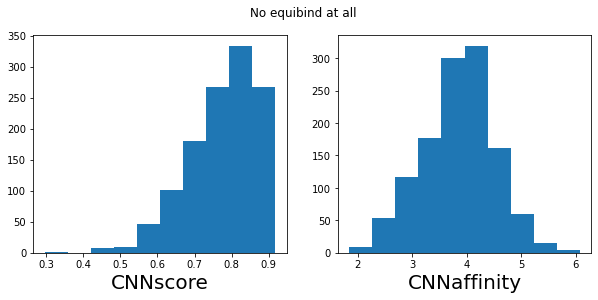

In [14]:
%matplotlib inline
plothists(cnndata, title)

Text(0, 0.5, 'Best binding glide')

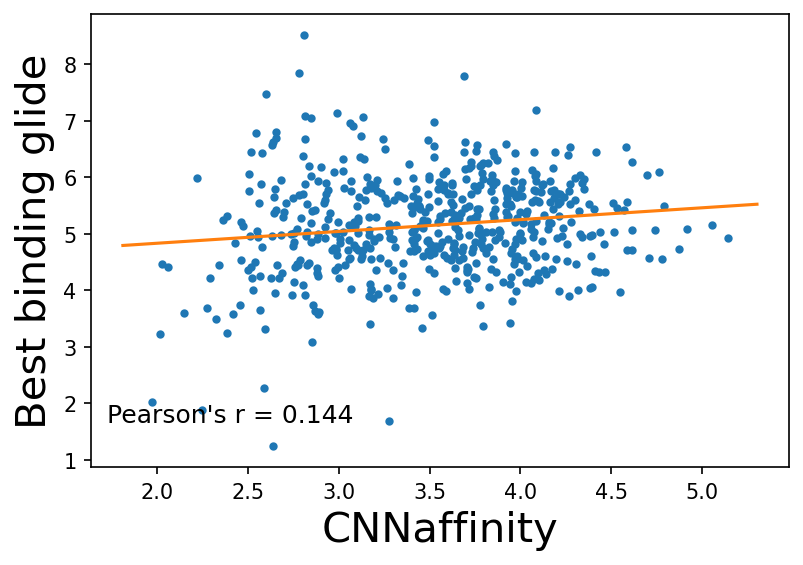

In [17]:
merge = cnndata.merge(glide[["name", "glidebest"]], on="name")
fig, ax = plt.subplots(dpi = 150)
# mask = pd.Series([True]*len(merge))
mask = merge["CNNscore"] > 0.8
x = list(merge["CNNaffinity"][mask])
y = list(merge["glidebest"][mask])
Linreg(x, y, ax = ax, fontsize = 12)
plt.gca().set_xlabel("CNNaffinity", fontsize = 20)
plt.gca().set_ylabel("Best binding glide", fontsize = 20)